In [1]:
# Scientific libraries
import numpy_html
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike') 
jtplot.style(context='talk', fscale=1, grid=False)

from glob import glob
import copy
import collections

#useful libraries
import daft

wine='#8F2727'

from betagen import betagen
dark, dark_highlight, mid, mid_highlight, light, light_highlight = betagen(wine)

import stan_utility

from bayescorner import bayescorner

#import warnings
#warnings.simplefilter('ignore')


### Generate synthetic data

We create our *observations* by selecting uniformly distributed data along the x-axis


In [29]:
np.random.seed(23542)

x_obs = np.random.uniform(1,40,35)

For simplicity, let's define a function to create a line

In [30]:
def linear(x,m=0.5, b=1. ):
    
    return m * x + b
    

Now, we will define the measurement process. Let's specify our true/latent model parameters

In [31]:
m_true = 0.5
b_true = 1.


y_true = linear(x_obs, m_true, b_true)

In [33]:
y_obs = np.random.poisson(y_true)

Let's take a look at the true and observed y values.

<IPython.core.display.Javascript object>


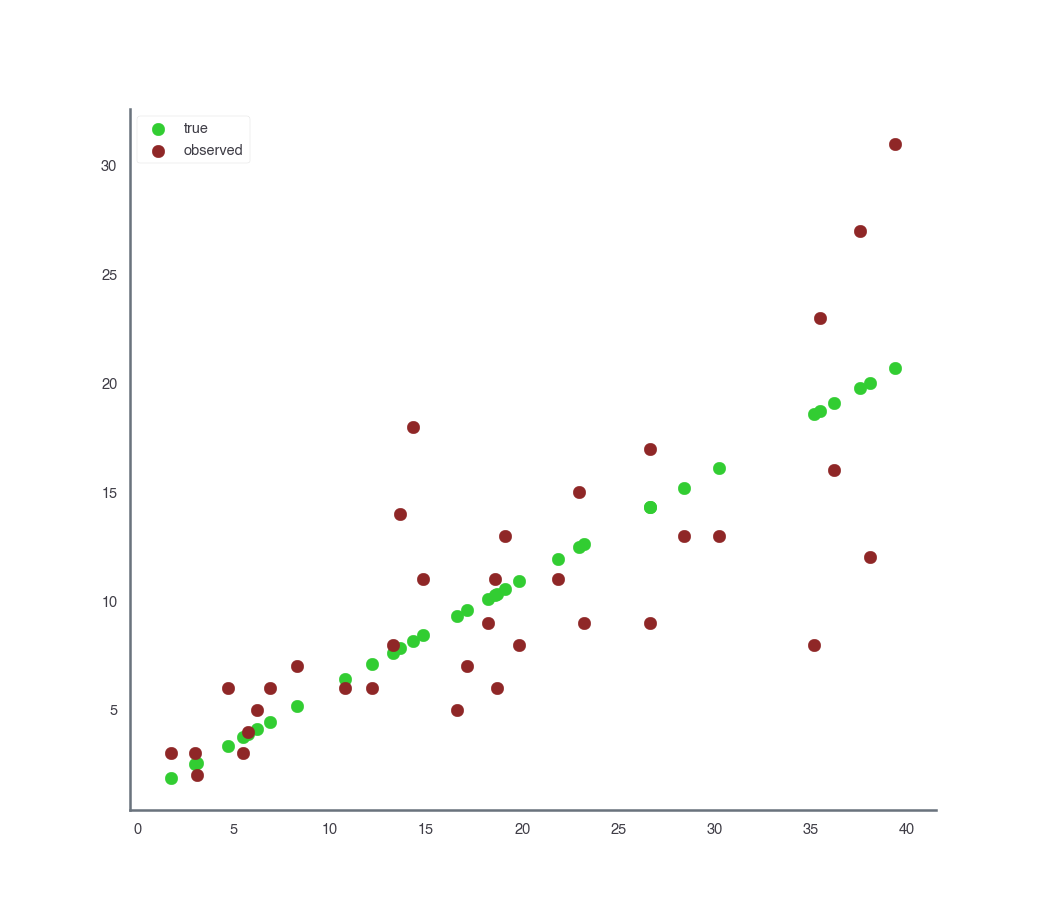

In [34]:
fig, ax = plt.subplots()


ax.scatter(x_obs, y_true, c='limegreen', label='true')
ax.scatter(x_obs, y_obs, c=dark, label='observed')
ax.legend()

<IPython.core.display.Javascript object>


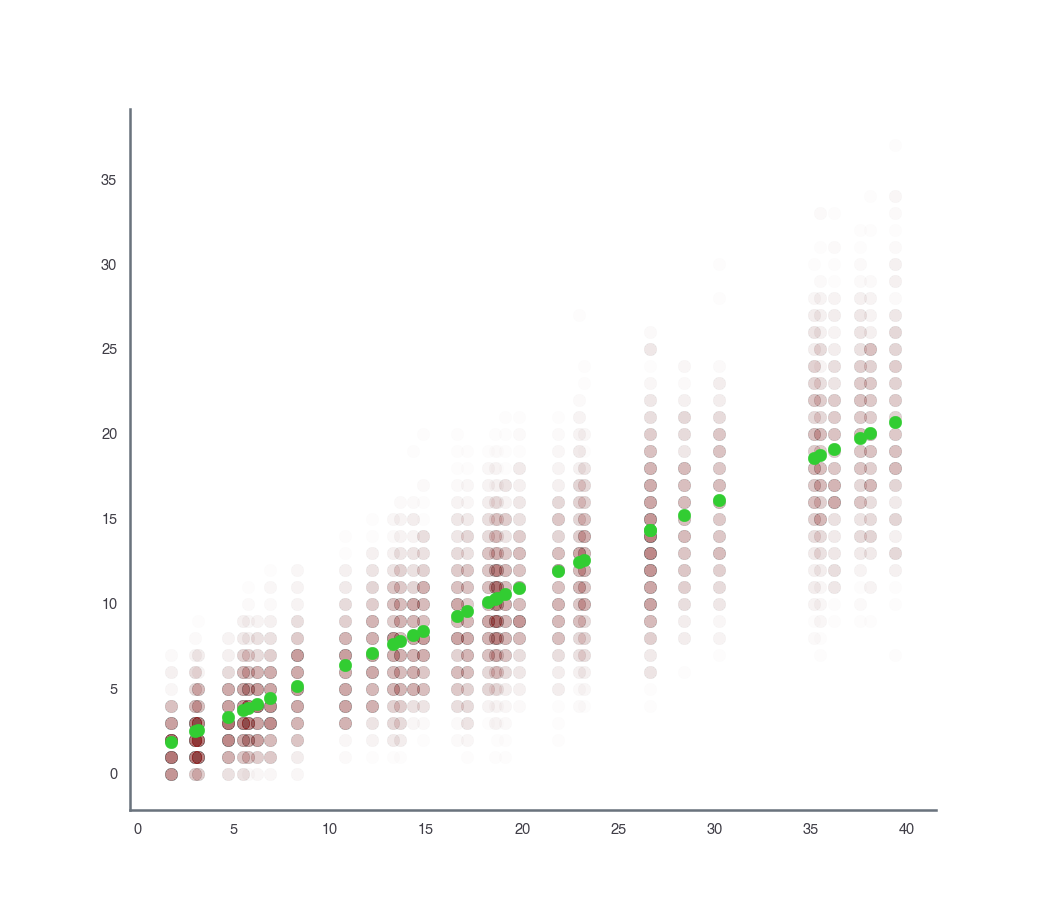

In [35]:
fig, ax = plt.subplots()


for i in range(250):
    
    y_obs_tmp = np.random.poisson(y_true)
    
    ax.scatter(x_obs, y_obs_tmp, c=dark, alpha=0.01)
    
ax.scatter(x_obs, y_true, c='limegreen')


Let's take a look at how we write a model in Stan

In [36]:
!cat fit_yline_poisson.stan

data {

  int<lower=0> N; // number of data points
  vector[N] x_obs; // x observations
  int y_obs[N]; // y observations  

  int<lower=0> N_model; // number of data points for line
  vector[N_model] x_model; //where to evaluate the model

}






parameters {
  
  real m; //slope of the line
  real b; //intercept of the line

}

transformed parameters {

  // latent y values not obscured by measurement error
  vector[N] y_true = m* x_obs + b;

}

model {

  // weakly informative priors

  m ~ normal(0,5);
  b ~ normal(0,5);

  // likelihood

  y_obs~ poisson(y_true);

  

}

generated quantities {

  
  vector[N] ppc;
  
  vector[N_model] line;

  
  // generate the posterior of the
  // fitted line
  line = m * x_model + b;

  // create posterior samples for PPC
  for (n in 1:N) {
    
    ppc[n] = poisson_rng(y_true[n]);

  }
  

}


In [37]:
stan_model = stan_utility.compile_model(filename='fit_yline_poisson.stan', model_name='yline_p')

Using cached StanModel


In [44]:
x_model = np.linspace(1,40,100)

stan_data = dict(N=len(x_obs),
                 x_obs=x_obs,
                 y_obs=y_obs,
                 sigma=y_sig,
                 N_model=100,
                 x_model=x_model)

In [45]:
fit = stan_model.sampling(data=stan_data,chains=4,iter=2000, seed=234571)

<IPython.core.display.Javascript object>


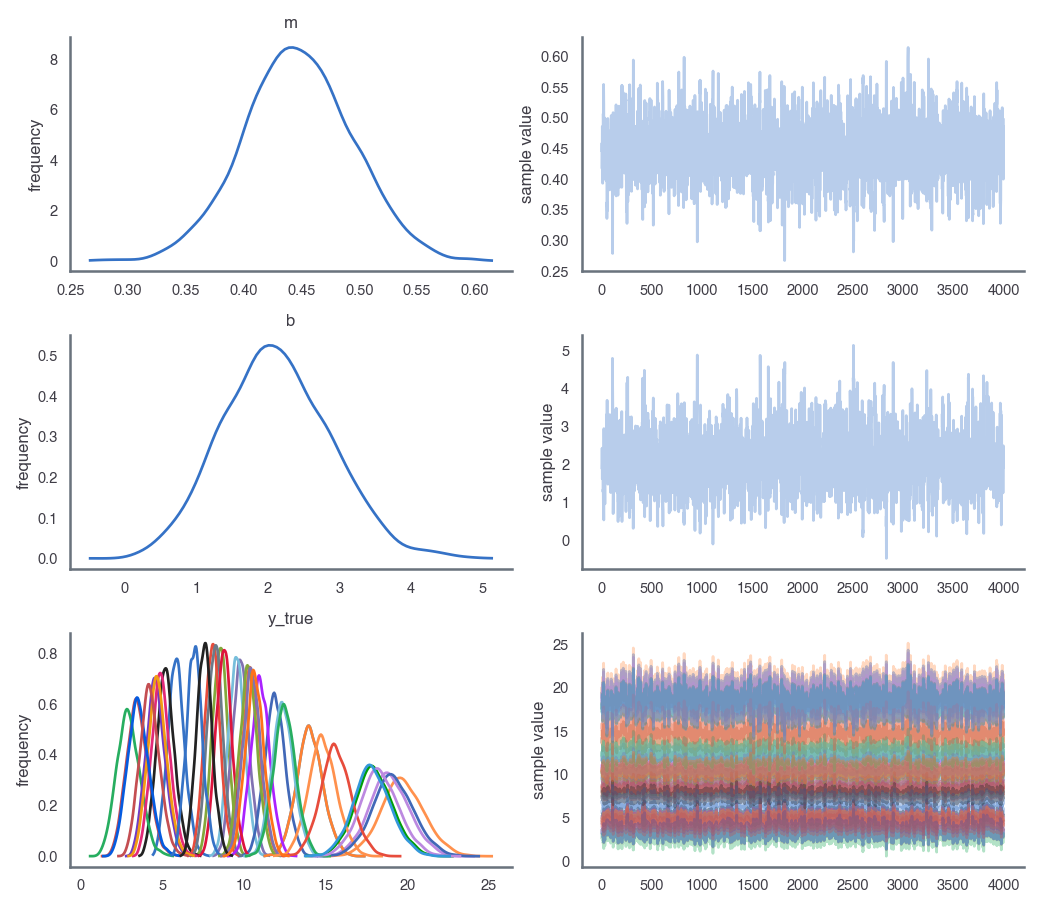

In [46]:
fit.plot(pars=['m', 'b', 'y_true'])
plt.tight_layout()

<IPython.core.display.Javascript object>


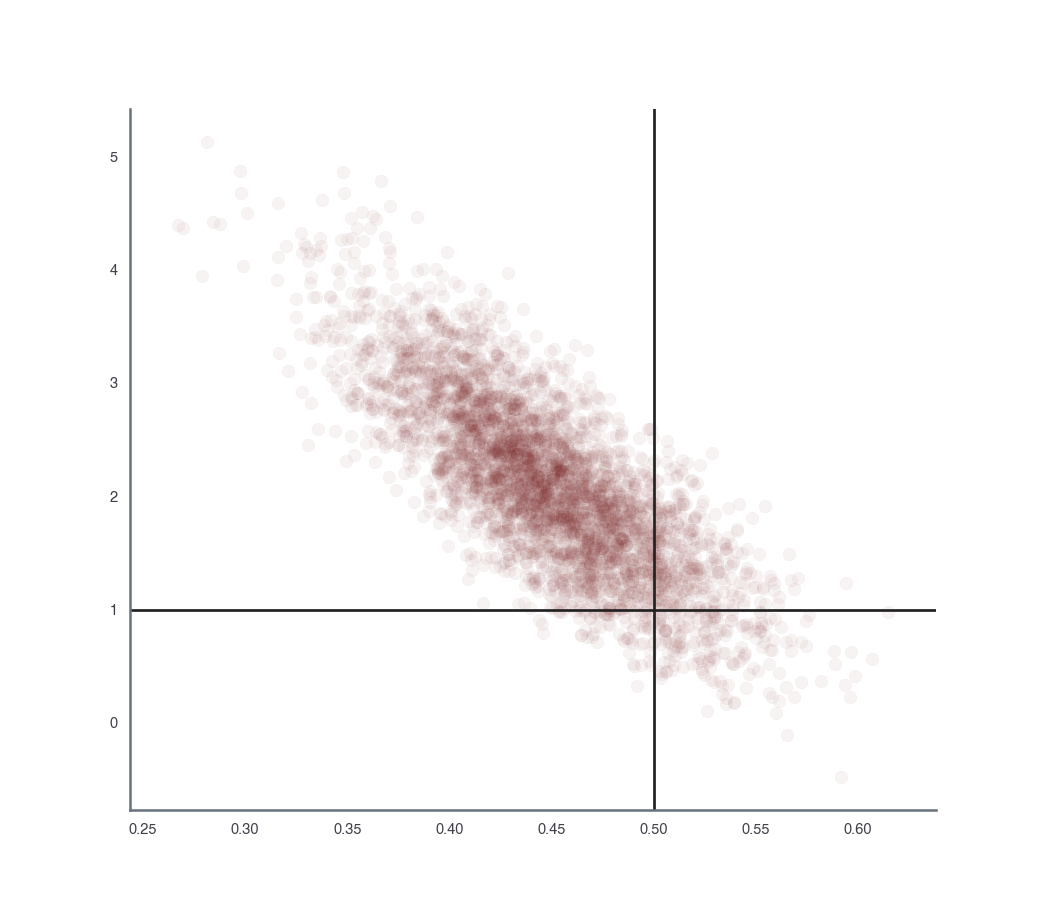

In [47]:
fig, ax = plt.subplots()

chain = fit.extract()


ax.scatter(chain['m'], chain['b'], c=dark_highlight, alpha=.05)


ax.axvline(m_true,color='k')
ax.axhline(b_true,color='k')

<IPython.core.display.Javascript object>


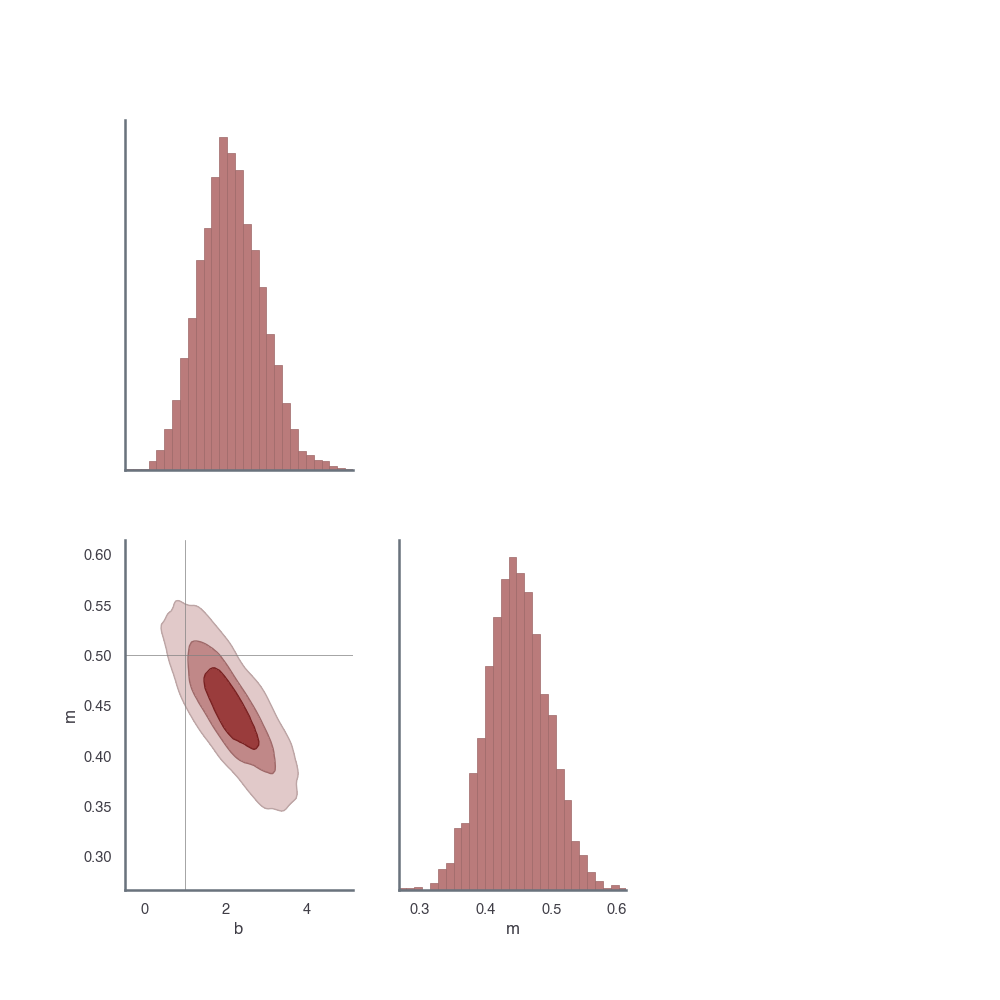

In [48]:
chain = fit.extract()

bayescorner(params=[chain['m'], chain['b']],
            param_names=['m', 'b'],
            truth=[m_true, b_true  ]
);

<IPython.core.display.Javascript object>


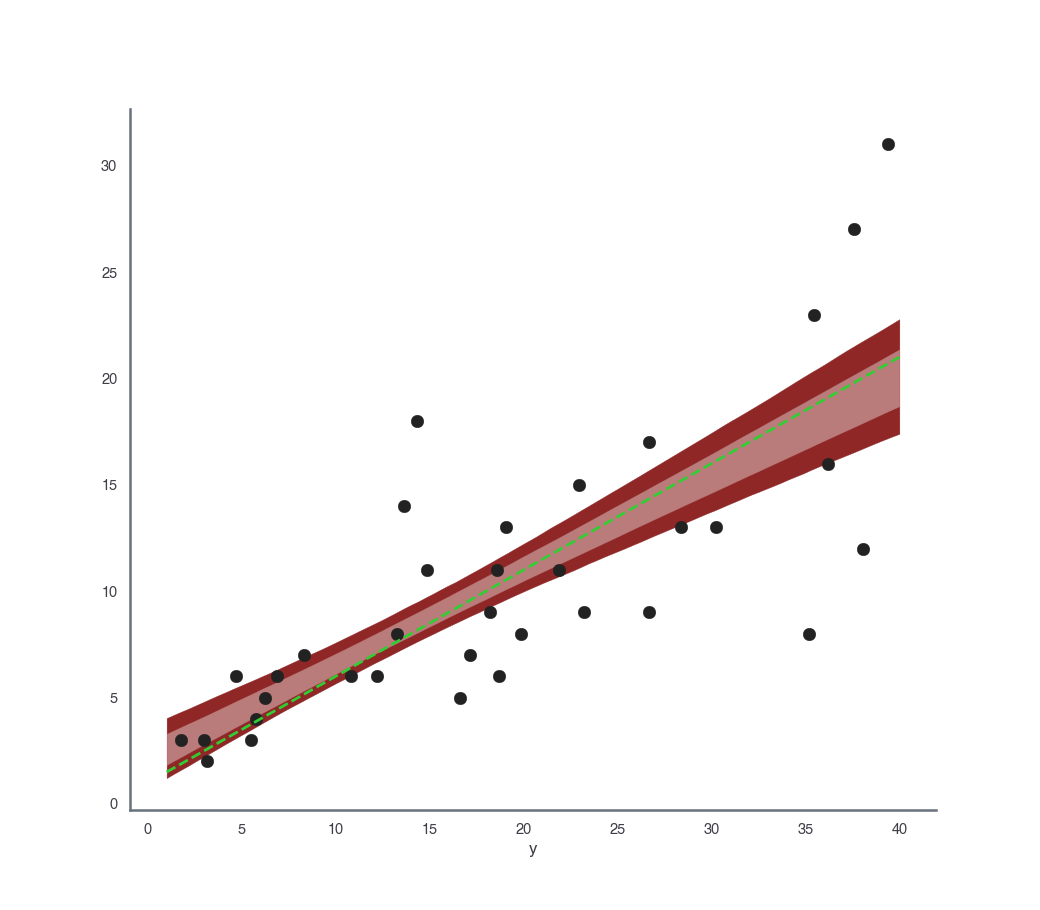

Text(0.5, 0, 'y')

In [49]:
fig, ax = plt.subplots()

chain = fit.extract()

level = 95

ax.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color=dark)

level = 68

ax.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color=mid)

ax.plot(x_model, m_true*x_model+b_true,color='limegreen',ls='--',zorder=10000)

ax.scatter(x_obs, y_obs, c='k')

ax.set_xlabel('x')
ax.set_xlabel('y')

<IPython.core.display.Javascript object>


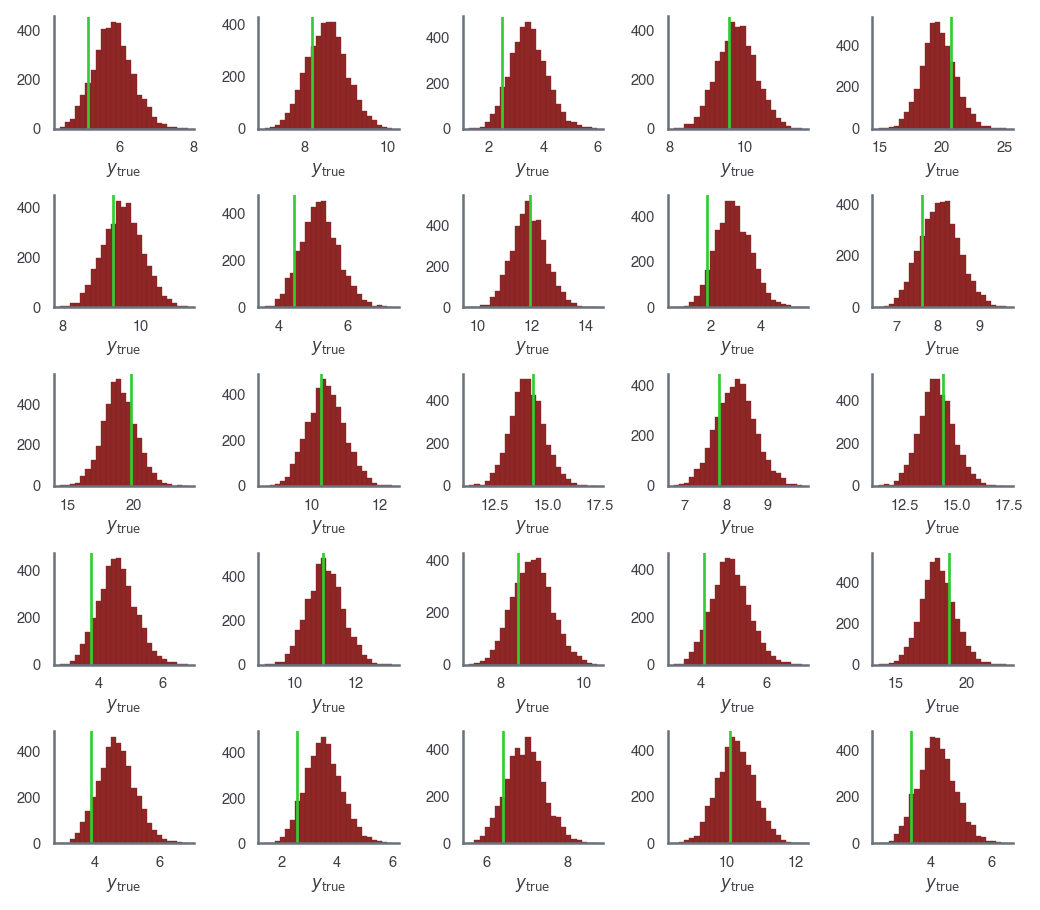

In [50]:
fig, axes = plt.subplots(5,5)

itr = 0

for i in range(5):
    for j in range(5):
        
        axes[i,j].hist(chain['y_true'][:,itr],ec=dark_highlight,fc=dark, bins=25)
        axes[i,j].axvline(y_true[itr],color='limegreen')
        axes[i,j].set_xlabel(r'$y_{\rm true}$')
        
        
        itr+=1
        
plt.tight_layout()

### Posterior Predictive Checks

An essential part of understanding a if a model that we conditioned on the data is an accurate description of that data is to ask the question of **"Does the posterior of the model generate data that looks like the data we observed?"** This is perfectly encapsulated within the concept of **posterior predictive checks**. First, we start with the posterior predictive distribution. 

$$
\pi\left(y^{\mathrm{rep}} | y\right)=\int d \theta \pi\left(y^{\mathrm{rep}} | \theta\right) \pi(\theta | y)
$$

In words, this distribution ask, what is the probability of future or replicated data given the data we observed. It is achieved by convolving the likelihood of future data with posterior of our model that we conditioned on the data we observed. 

Stan allows us to easily compute this future data by drawing replicated data from the likelihood at each iteration of our MCMC. There are several ways to access PPCs that vary from problem to problem. Here, we plot these replicated data along with our observed data and visually confirm that indeed our model and its uncertainty can generate data that look like our observed data 



<IPython.core.display.Javascript object>


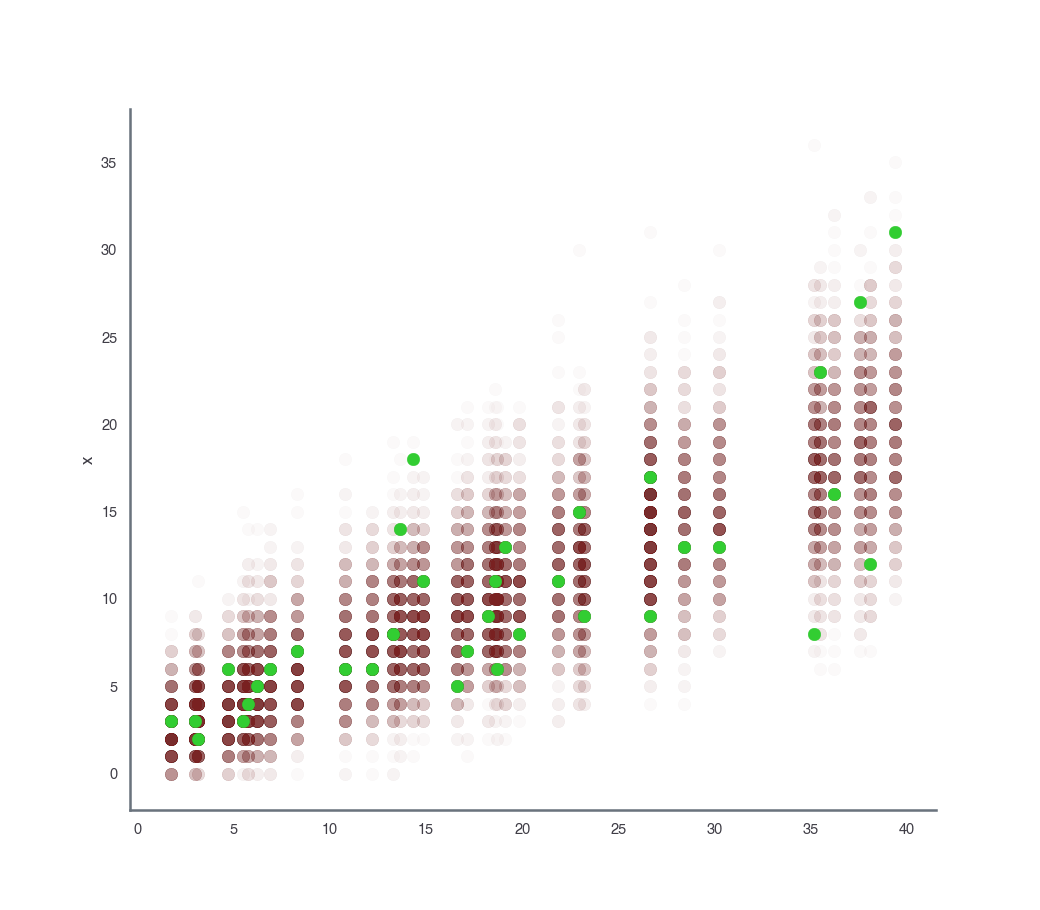

Text(0, 0.5, 'x')

In [51]:
fig, ax = plt.subplots()


for ppc in chain['ppc'][::10]:
    
    ax.scatter(x_obs,ppc, c=dark_highlight, alpha=.025)
    
    
ax.scatter(x_obs, y_obs,c='limegreen')


ax.set_ylabel('y')
ax.set_ylabel('x')

<IPython.core.display.Javascript object>


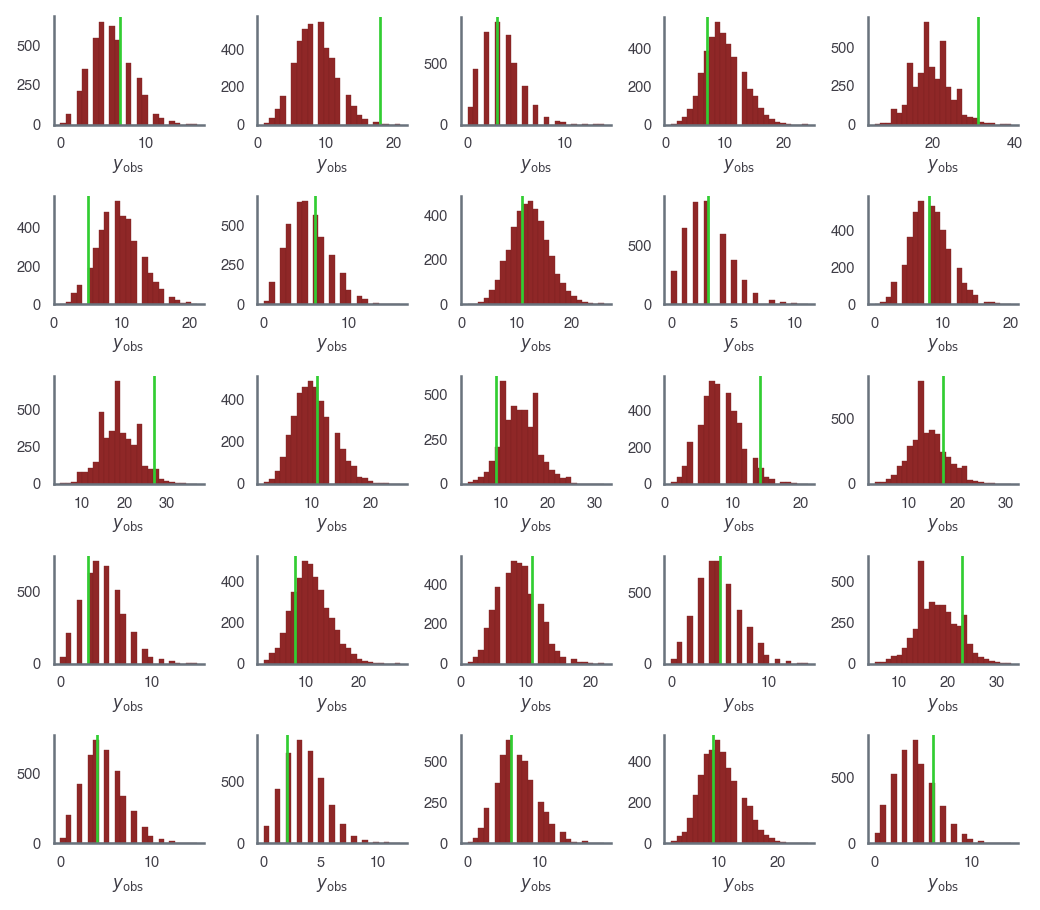

In [52]:
fig, axes = plt.subplots(5,5)

itr = 0

for i in range(5):
    for j in range(5):
        
        axes[i,j].hist(chain['ppc'][:,itr],ec=dark_highlight,fc=dark, bins=25)
        axes[i,j].axvline(y_obs[itr],color='limegreen')
        axes[i,j].set_xlabel(r'$y_{\rm obs}$')
        
        
        itr+=1
        
plt.tight_layout()